# Build a 4x4 - test image

In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

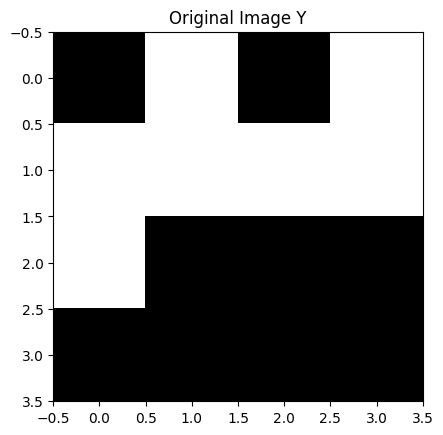

In [43]:
image = torch.tensor([[0,1,0,1],[1,1,1,1],[1,0,0,0],[0,0,0,0]],dtype=torch.float32)
plt.imshow(image,cmap="gray")
plt.title("Original Image Y")
plt.show()

# Step 1: Build a masked image

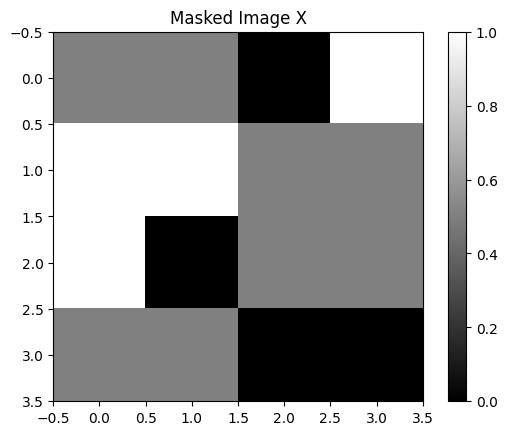

tensor([[0.5000, 0.5000, 0.0000, 1.0000],
        [1.0000, 1.0000, 0.5000, 0.5000],
        [1.0000, 0.0000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.0000, 0.0000]])

In [44]:
# mask half the patches
masked_image = image.clone()
masked_image[0,0:2] = 0.5
masked_image[1,2:4] = 0.5
masked_image[2,2:4] = 0.5
masked_image[3,0:2] = 0.5
plt.imshow(masked_image,cmap="gray")
plt.title("Masked Image X")
plt.colorbar()
plt.show()
masked_image

In [45]:
# Change the dimensions
masked_patches = torch.zeros(1,8,2) # (batch_size,num_patches,embed_dim)
for i in range(8):
    if i%2 == 0:
        masked_patches[0,i,:] = masked_image[int(i/2),0:2]
    else:
        masked_patches[0,i,:] = masked_image[int((i-1)/2),2:4]
print("masked patches: ", masked_patches)

masked patches:  tensor([[[0.5000, 0.5000],
         [0.0000, 1.0000],
         [1.0000, 1.0000],
         [0.5000, 0.5000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.0000, 0.0000]]])


# Visualize the Vector Embeddings

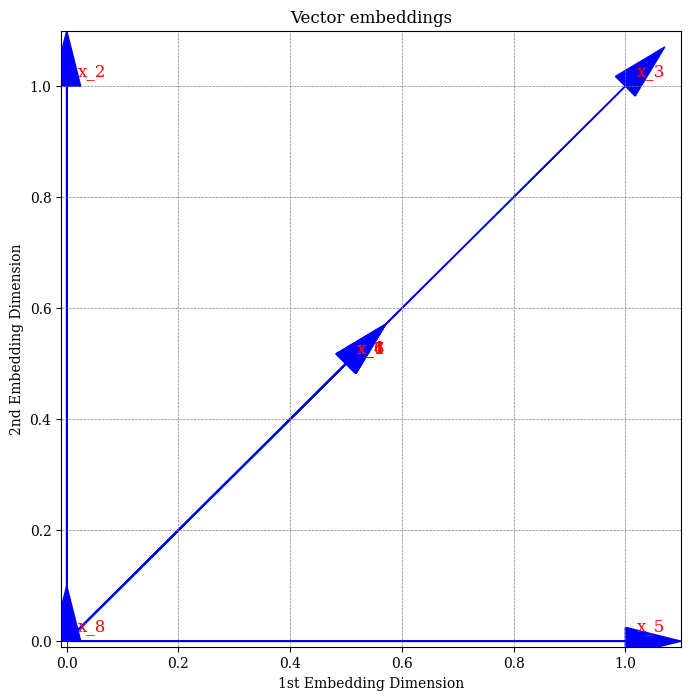

In [74]:
# Convert to NumPy for easier plotting
vectors = masked_patches.squeeze(0).detach().numpy()

# Separate the x and y components (embedding dimensions)
x_components = vectors[:, 0]  # 1st embedding dimension
y_components = vectors[:, 1]  # 2nd embedding dimension

# Ensure no LaTeX is used
plt.rcParams['text.usetex'] = False

# Create the plot
plt.figure(figsize=(8, 8))
for i in range(len(vectors)):
    # Draw the arrow
    plt.arrow(0, 0, x_components[i], y_components[i], 
              head_width=0.05, head_length=0.1, fc='blue', ec='blue')

    # Add plain text label above the arrow
    label = f"x_{i+1}"  # Simple plain text label
    plt.text(x_components[i] + 0.02, y_components[i] + 0.02, label, fontsize=12, color="red")

# Add labels and grid
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title("Vector embeddings")
plt.xlabel("1st Embedding Dimension")
plt.ylabel("2nd Embedding Dimension")

# Set axis limits for better visualization
plt.xlim(min(x_components)-0.01, max(x_components)+0.1)
plt.ylim(min(y_components)-0.01, max(y_components)+0.1)

plt.show()

# Step 2: build Z = XA^T + b

In [77]:
# Add a linear layer
x = masked_patches.permute(1, 0, 2)  # (num_patches, batch_size, embed_dim)
print("x: ", x)
lin_layer = nn.Linear(2,3)
z = lin_layer(x) # (num_patches,batch_size,hidden_dim)
print("z: ", z)
print("z dim:", z.size())

x:  tensor([[[0.5000, 0.5000]],

        [[0.0000, 1.0000]],

        [[1.0000, 1.0000]],

        [[0.5000, 0.5000]],

        [[1.0000, 0.0000]],

        [[0.5000, 0.5000]],

        [[0.5000, 0.5000]],

        [[0.0000, 0.0000]]])
z:  tensor([[[-0.6834, -0.1474, -0.8519]],

        [[-0.5233,  0.0063, -0.4998]],

        [[-0.6758,  0.1209, -1.0086]],

        [[-0.6834, -0.1474, -0.8519]],

        [[-0.8436, -0.3011, -1.2041]],

        [[-0.6834, -0.1474, -0.8519]],

        [[-0.6834, -0.1474, -0.8519]],

        [[-0.6911, -0.4157, -0.6953]]], grad_fn=<ViewBackward0>)
z dim: torch.Size([8, 1, 3])


# Visualize the Z vectors. 

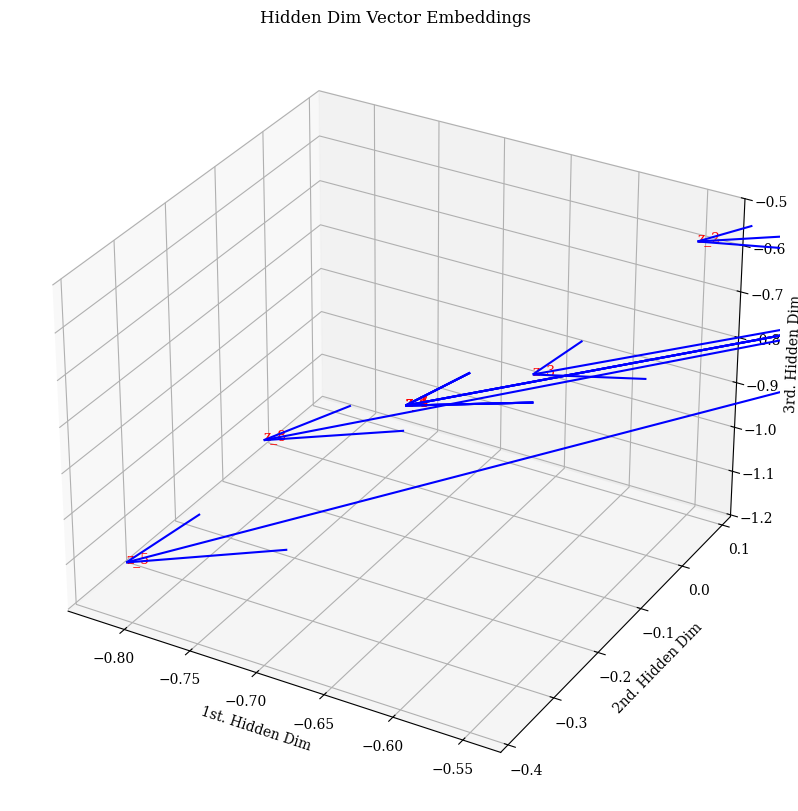

In [79]:
# Reshape to [8, 3] for easier manipulation
vectors = z.squeeze(1).detach().numpy()

# Extract components
x_components = vectors[:, 0]  # X components
y_components = vectors[:, 1]  # Y components
z_components = vectors[:, 2]  # Z components

# Set up 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all vectors originating from the origin (0, 0, 0)
for i in range(len(vectors)):
    ax.quiver(0, 0, 0, x_components[i], y_components[i], z_components[i], 
              arrow_length_ratio=0.1, color='blue')

    # Add a label for each vector
    ax.text(x_components[i], y_components[i], z_components[i], f"z_{i+1}", color="red", fontsize=10)

# Set labels and limits
ax.set_title("Hidden Dim Vector Embeddings")
ax.set_xlabel("1st. Hidden Dim")
ax.set_ylabel("2nd. Hidden Dim")
ax.set_zlabel("3rd. Hidden Dim")

# Adjust view limits
ax.set_xlim([min(x_components), max(x_components)])
ax.set_ylim([min(y_components), max(y_components)])
ax.set_zlim([min(z_components), max(z_components)])

plt.show()

# Step 3: Add a Positional Embedding

In [80]:
positional_embedding = nn.Parameter(torch.randn(8, 1, 3))  # Shape: (num_patches, 1, hidden_dim)
z = z + positional_embedding
print("z + positional embedding: ", z)

z + positional embedding:  tensor([[[-0.1038, -1.2922, -0.0676]],

        [[ 1.5324, -0.4483, -1.4029]],

        [[-0.4854, -0.5906, -0.4573]],

        [[-1.4439,  2.3789, -4.1492]],

        [[-0.8702, -0.9467, -1.7612]],

        [[ 0.5311,  0.4442, -0.9876]],

        [[-1.2356,  0.8206, -2.3787]],

        [[-0.9386, -2.3498, -1.7432]]], grad_fn=<AddBackward0>)


# Visualize with the Positional Embeddings

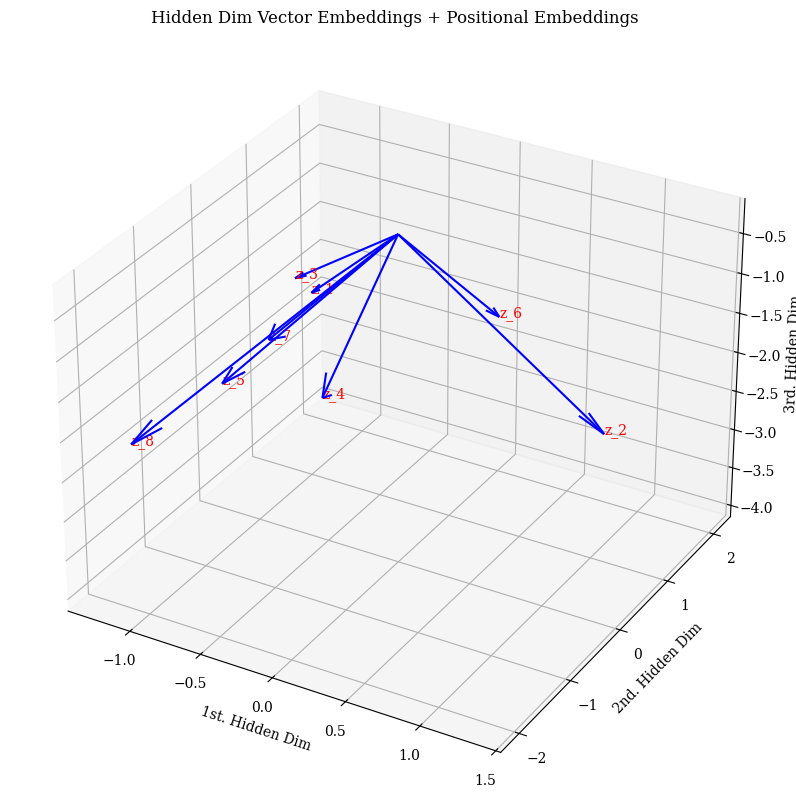

In [81]:
# Reshape to [8, 3] for easier manipulation
vectors = z.squeeze(1).detach().numpy()

# Extract components
x_components = vectors[:, 0]  # X components
y_components = vectors[:, 1]  # Y components
z_components = vectors[:, 2]  # Z components

# Set up 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all vectors originating from the origin (0, 0, 0)
for i in range(len(vectors)):
    ax.quiver(0, 0, 0, x_components[i], y_components[i], z_components[i], 
              arrow_length_ratio=0.1, color='blue')

    # Add a label for each vector
    ax.text(x_components[i], y_components[i], z_components[i], f"z_{i+1}", color="red", fontsize=10)

# Set labels and limits
ax.set_title("Hidden Dim Vector Embeddings + Positional Embeddings")
ax.set_xlabel("1st. Hidden Dim")
ax.set_ylabel("2nd. Hidden Dim")
ax.set_zlabel("3rd. Hidden Dim")

# Adjust view limits
ax.set_xlim([min(x_components), max(x_components)])
ax.set_ylim([min(y_components), max(y_components)])
ax.set_zlim([min(z_components), max(z_components)])

plt.show()

# Step 4: Get the attention output

In [35]:
seq_len, batch_size, hidden_dim = z.size()

# Apply LayerNorm
lay_norm = nn.LayerNorm(4)
z_norm = lay_norm(z)

attention = nn.MultiheadAttention(embed_dim=4, num_heads=1, dropout=0.0)
# Self-attention
attn_output, attn_weights = attention(z_norm, z_norm, z_norm)  # Shape: (num_patches, batch_size, hidden_dim)
print("size of context vector: ", attn_output.size())
print("size of QK^T-matrix: ", attn_weights.size())

size of context vector:  torch.Size([8, 1, 4])
size of QK^T-matrix:  torch.Size([1, 8, 8])


# Step 5: Visualize the attention scores

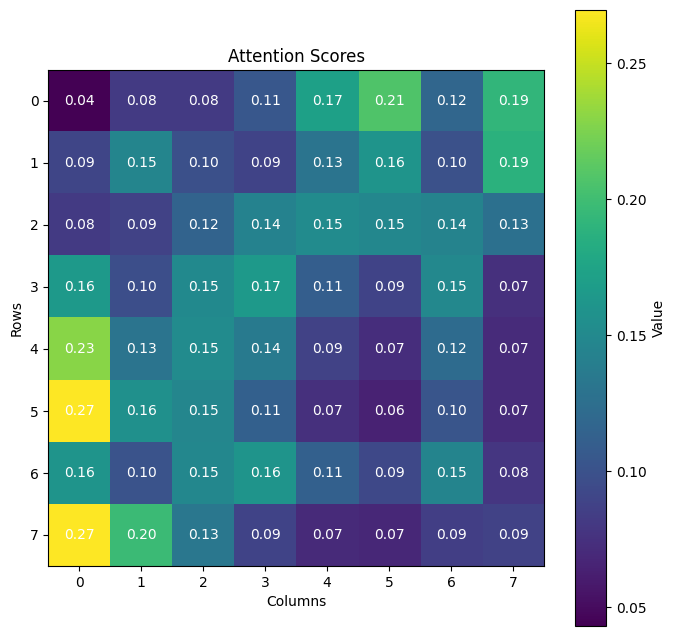

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Example tensor of size (1, 8, 8)
tensor = attn_weights

# Extract the 2D matrix
matrix = tensor.squeeze(0).detach().numpy()

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(matrix, cmap="viridis", interpolation="nearest")  # Use a colormap
plt.colorbar(label="Value")  # Add a color scale

# Annotate the values on the heatmap
for i in range(matrix.shape[0]):  # Loop over rows
    for j in range(matrix.shape[1]):  # Loop over columns
        plt.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="white" if matrix[i, j] < 0.5 else "black")

# Add labels and title
plt.title("Attention Scores")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# Step 5: Visualize the Context Vectors. 